In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import gc

from scipy import signal
import lightgbm as lgb

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [2]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [3]:
targets = y_train['surface'].value_counts().index
print(targets)
print(y_train['surface'].value_counts())

Index(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
       'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles'],
      dtype='object')
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


In [4]:
target_to_id = {}
id_to_target = {}

for target in targets:
    if target not in target_to_id:
        new_id = len(target_to_id)
        target_to_id[target] = new_id
        id_to_target[new_id] = target

In [5]:
y_id = []
for i in range(len(y_train)):
    y_id.append(target_to_id[y_train['surface'].values[i]])
y_id = np.asarray(y_id)

In [6]:
class_num = len(targets)

In [7]:
y_id_one = np.zeros((len(y_id), class_num))
for i in range(len(y_id)):
    y_id_one[i, y_id[i]] = 1 

In [8]:
def norm_quat(df):
    norm = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)**0.5
    df['orientation_X'] /= norm
    df['orientation_Y'] /= norm
    df['orientation_Z'] /= norm
    df['orientation_W'] /= norm
    return df

In [9]:
import math

def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [10]:
X_train = norm_quat(X_train)
X_test = norm_quat(X_test)

In [11]:
def fe_step1 (df):
    """Quaternions to Euler Angles"""
    
    x = df['orientation_X'].values
    y = df['orientation_Y'].values
    z = df['orientation_Z'].values
    w = df['orientation_W'].values
    nx, ny, nz = np.zeros(len(x)), np.zeros(len(y)), np.zeros(len(z)),
    for i in tqdm(range(len(x))):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx[i] = xx
        ny[i] = yy
        nz[i] = zz
    
    df['euler_X'] = nx
    df['euler_Y'] = ny
    df['euler_Z'] = nz
    return df

In [12]:
X_train = fe_step1(X_train)
X_test = fe_step1(X_test)

100%|██████████| 488448/488448 [00:01<00:00, 308755.10it/s]


In [13]:
def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

In [14]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843197,-0.024785,1.396698


In [16]:
dt = 0.1
ang = 0
ang_list=[ang]

angZ = X_train['angular_velocity_Z'].values[:128]
for i in range(1, 128):
    ang = ((angZ[i]+angZ[i-1])*dt)/2 +ang
    ang_list.append(ang)

In [17]:
ang_list

[0,
 0.00020764549999999996,
 7.800549999999995e-05,
 -0.0006695845000000001,
 -0.0008559995000000001,
 -0.0012552895,
 -0.0020516195,
 -0.0033329494999999997,
 -0.0048710294999999995,
 -0.005761079499999999,
 -0.0070890495,
 -0.0082080295,
 -0.0100066095,
 -0.0120553095,
 -0.0138986095,
 -0.0165227095,
 -0.0183942595,
 -0.020033159499999998,
 -0.022027759499999997,
 -0.0242489095,
 -0.026295509499999998,
 -0.027571859499999997,
 -0.0285631445,
 -0.029397314499999997,
 -0.0300351595,
 -0.0296701695,
 -0.0293103945,
 -0.0291642145,
 -0.0284014995,
 -0.0271071895,
 -0.0256821245,
 -0.0251684835,
 -0.0244803575,
 -0.0231915075,
 -0.0224263475,
 -0.021965897499999998,
 -0.021380057499999997,
 -0.0201141075,
 -0.0184351575,
 -0.0173528725,
 -0.0165192275,
 -0.0151435675,
 -0.012898067499999999,
 -0.011195777499999999,
 -0.010371822499999999,
 -0.0092323575,
 -0.0078477575,
 -0.0071896395,
 -0.0069713365,
 -0.0067350775,
 -0.0065410634999999995,
 -0.0066864985,
 -0.0077859235,
 -0.0090093235

In [21]:
import scipy
scipy.__version__

'1.1.0'

In [22]:
def rotation_matrix(q0, q1, q2, q3):
    r00 = q0**2 + q1**2 - q2**2 - q3**2
    r01 = 2 * (q1*q2 - q0*q3)
    r02 = 2 * (q0*q2 + q1*q3)
    r10 = 2 * (q0*q3 + q1*q2)
    r11 = q0**2 - q1**2 + q2**2 - q3**2
    r12 = 2 * (-q0*q1 + q2*q3)
    r20 = 2 * (q1*q3 - q0*q2)
    r21 = 2 * (q2*q3 + q0*q1)
    r22 = q0**2 - q1**2 - q2**2 + q3**2
    R = np.array([[r00, r01, r02],[r10, r11, r12],[r20, r21, r22]])
    return R

In [27]:
np.dot(np.array([i for i in range(1, 10)]).reshape(3,3), np.array([i for i in range(1, 4)]))

array([14, 32, 50])

In [29]:
def rotated_acceleration(df):
    
    df['rotated_acceleration_X'] = 0
    df['rotated_acceleration_Y'] = 0
    df['rotated_acceleration_Z'] = 0
    
    for i in tqdm(range(len(df))):
        q0 = df['orientation_X'].values[i]
        q1 = df['orientation_Y'].values[i]
        q2 = df['orientation_Z'].values[i]
        q3 = df['orientation_W'].values[i]
        R = rotation_matrix(q0, q1, q2, q3)
        la = np.array([df['linear_acceleration_X'].values[i], df['linear_acceleration_Y'].values[i], df['linear_acceleration_Z'].values[i]])
        rotated_la = np.dot(R, la)
        
        df.loc[i, 'rotated_acceleration_X'] = rotated_la[0]
        df.loc[i, 'rotated_acceleration_Y'] = rotated_la[1]
        df.loc[i, 'rotated_acceleration_Z'] = rotated_la[2]
    
    return df

In [30]:
X_train = rotated_acceleration(X_train)

100%|██████████| 487680/487680 [23:47<00:00, 341.70it/s]


In [31]:
X_test = rotated_acceleration(X_test)

100%|██████████| 488448/488448 [21:40<00:00, 375.53it/s]


In [32]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z,rotated_acceleration_X,rotated_acceleration_Y,rotated_acceleration_Z
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843273,-0.024668,1.396667,-3.636639,9.312513,0.399795
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843201,-0.024662,1.396651,-2.480732,9.209091,-0.155641
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843222,-0.024728,1.396677,-2.858829,8.401392,0.062818
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843183,-0.024769,1.396712,-2.587259,9.806553,-0.676377
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843197,-0.024785,1.396698,-3.593514,9.919510,-0.349151


In [ ]:
def process_subtrain(arg_tuple):
    start, end, idx = arg_tuple
    X_tr = X_train.iloc[start:end, :]
    X_tr = rotated_acceleration(X_tr)
    return idx, X_tr

In [ ]:
all_chunks = []

num_cores = 8 
total_size = len(X_train)
chunk_size = total_size/num_cores

for i in range(8):
    start_idx = int(i * chunk_size)
    end_idx = int(start_idx + chunk_size)
    chunk = (start_idx, end_idx, i)
    all_chunks.append(chunk)

pool = Pool()
results = pool.map(process_subtrain, all_chunks)    
results = sorted(results, key=lambda tup: tup[0])

In [14]:
def lowpass_filter(data, r=0.05):
    f_data = np.zeros_like(data)
    f_data[0] = data[0]
    for i in range(1, len(data)):
        if i % 128 == 0:
            f_data[i] = data[i]
        else:
            f_data[i] = r * data[i] + (1-r) * f_data[i-1]
    return f_data

In [67]:
for data in [X_train, X_test]:
    data['linear_acceleration_X'] = lowpass_filter(data['linear_acceleration_X'])
    data['linear_acceleration_Y'] = lowpass_filter(data['linear_acceleration_Y'])
    data['linear_acceleration_Z'] = lowpass_filter(data['linear_acceleration_Z'])
    data['angular_velocity_X'] = lowpass_filter(data['angular_velocity_X'])
    data['angular_velocity_Y'] = lowpass_filter(data['angular_velocity_Y'])
    data['angular_velocity_Z'] = lowpass_filter(data['angular_velocity_Z'])

In [68]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak = pd.DataFrame()

for i in tqdm(range(0, len(X_train), 128)):
    X_tr = X_train.iloc[i:i+128, :]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak = pd.concat([df_peak, df_cols], axis=0)

100%|██████████| 3810/3810 [01:08<00:00, 55.62it/s]


In [70]:
cols = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
df_peak_te = pd.DataFrame()

for i in tqdm(range(0, len(X_test), 128)):
    X_tr = X_test.iloc[i:i+128, :]
    df_cols = pd.DataFrame()
    for col in cols:
        peaks = signal.find_peaks(X_tr[col], rel_height=1.0)[0]
        peak_num = len(peaks)
        peak_width = signal.peak_widths(X_tr[col], peaks, rel_height=1.0)[0]
        peak_pro = signal.peak_prominences(X_tr[col], peaks)[0]
        
        if peak_num != 0:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[np.max(peak_width)],
                             col+'_peak_width_min':[np.min(peak_width)],
                             col+'_peak_width_mean':[np.mean(peak_width)],
                             col+'_peak_pro_max':[np.max(peak_pro)],
                             col+'_peak_pro_min':[np.min(peak_pro)],
                             col+'_peak_pro_mean':[np.mean(peak_pro)]
                            }, index=[i//128])
        else:
            peak_df = pd.DataFrame({
                             col+'_peak_num':[peak_num], 
                             col+'_peak_width_max':[0],
                             col+'_peak_width_min':[0],
                             col+'_peak_width_mean':[0],
                             col+'_peak_pro_max':[0],
                             col+'_peak_pro_min':[0],
                             col+'_peak_pro_mean':[0]
                            }, index=[i//128])
            
        df_cols = pd.concat([df_cols, peak_df], axis=1)
    df_peak_te = pd.concat([df_peak_te, df_cols], axis=0)

100%|██████████| 3816/3816 [01:07<00:00, 56.58it/s]


In [69]:
df_peak.head()

,linear_acceleration_X_peak_num,linear_acceleration_X_peak_width_max,linear_acceleration_X_peak_width_min,linear_acceleration_X_peak_width_mean,linear_acceleration_X_peak_pro_max,linear_acceleration_X_peak_pro_min,linear_acceleration_X_peak_pro_mean,linear_acceleration_Y_peak_num,linear_acceleration_Y_peak_width_max,linear_acceleration_Y_peak_width_min,linear_acceleration_Y_peak_width_mean,linear_acceleration_Y_peak_pro_max,linear_acceleration_Y_peak_pro_min,linear_acceleration_Y_peak_pro_mean,linear_acceleration_Z_peak_num,linear_acceleration_Z_peak_width_max,linear_acceleration_Z_peak_width_min,linear_acceleration_Z_peak_width_mean,linear_acceleration_Z_peak_pro_max,linear_acceleration_Z_peak_pro_min,linear_acceleration_Z_peak_pro_mean,angular_velocity_X_peak_num,angular_velocity_X_peak_width_max,angular_velocity_X_peak_width_min,angular_velocity_X_peak_width_mean,angular_velocity_X_peak_pro_max,angular_velocity_X_peak_pro_min,angular_velocity_X_peak_pro_mean,angular_velocity_Y_peak_num,angular_velocity_Y_peak_width_max,angular_velocity_Y_peak_width_min,angular_velocity_Y_peak_width_mean,angular_velocity_Y_peak_pro_max,angular_velocity_Y_peak_pro_min,angular_velocity_Y_peak_pro_mean,angular_velocity_Z_peak_num,angular_velocity_Z_peak_width_max,angular_velocity_Z_peak_width_min,angular_velocity_Z_peak_width_mean,angular_velocity_Z_peak_pro_max,angular_velocity_Z_peak_pro_min,angular_velocity_Z_peak_pro_mean
0,18,67.349799,1.020952,8.738154,0.869510,0.000358,0.110924,8,50.696731,1.395732,12.711851,1.320872,0.005401,0.314191,20,56.355945,1.150822,10.368243,0.378517,0.004492,0.126852,12,39.834934,1.617261,7.003719,0.034600,0.000301,0.004765,20,41.757057,1.040009,6.503980,0.023187,6.329349e-05,0.002656,11,42.250167,1.039925,8.342229,0.009851,0.000008,0.002005
1,27,33.713893,1.014982,4.154307,0.537557,0.000869,0.061414,13,48.564414,1.004925,8.686394,2.080121,0.000290,0.249105,22,109.833935,1.575330,12.974075,0.639242,0.004951,0.199470,17,40.939492,1.115794,4.805293,0.046299,0.000237,0.005848,26,43.509612,1.214623,5.869483,0.017523,1.139008e-04,0.003568,5,70.046581,18.703546,30.604017,0.043476,0.026268,0.034705
2,42,57.395712,1.010786,5.210292,0.295711,0.000664,0.040441,10,53.496276,1.265500,9.771990,1.693452,0.005750,0.304578,17,28.214848,1.327078,6.505685,0.306442,0.008605,0.087387,12,54.990935,1.478589,10.768762,0.063062,0.000331,0.010688,30,75.135188,1.000653,6.599449,0.011325,7.132009e-07,0.002586,14,24.152079,1.060126,5.835102,0.012037,0.000043,0.002172
3,39,36.895928,1.018780,3.726208,0.628153,0.001037,0.080369,5,54.040205,1.028376,19.295784,4.109290,0.002904,1.507230,21,40.926006,1.165514,10.832781,0.977948,0.028928,0.327467,14,49.361726,1.300930,7.417091,0.126019,0.001908,0.018159,24,58.726325,1.021230,6.350322,0.015169,3.202688e-05,0.003391,14,40.545125,1.011690,7.527733,0.012205,0.000015,0.002717
4,14,83.441060,1.011932,11.847188,0.460989,0.000241,0.069680,6,55.824354,1.533987,13.385387,1.090068,0.008584,0.218788,19,52.447764,1.196776,9.038149,0.256213,0.005018,0.095783,13,60.704755,1.165449,8.980491,0.035348,0.000088,0.005392,15,35.420688,1.462859,6.634628,0.006241,8.749217e-05,0.001295,5,46.757172,13.165737,21.755833,0.020428,0.003924,0.009956


In [33]:
def feat_eng(df):
    data = pd.DataFrame()
    #df['linear_acceleration_Z'] += 9.80665
    #df['eulerX-Z'] = df['euler_X']-df['euler_Z']
    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    #df['total_ang_cos'] = (df['angular_velocity_X_cos']**2 + df['angular_velocity_Y_cos']**2 + df['angular_velocity_Z_cos']**2)**0.5
    
    tmp_df = pd.concat([df['linear_acceleration_Z'], df['angular_velocity_X']], axis=1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tmp_df = scaler.fit_transform(tmp_df)
    
    #df['total_angu'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)**0.5
    
    #df['total_eule'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    #df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    #df['total_acc/vel'] = df['total_acce']/df['total_angu']
    
    df_columns = df.columns[7:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [35]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

KeyError: 'linear_acceleration_X'

In [36]:
X_train.shape

(3810, 156)

In [73]:
df_peak.shape

(3810, 42)

In [74]:
df_peak_te.shape

(3816, 42)

In [75]:
X_test.shape

(3816, 84)

In [76]:
X_train = pd.concat([X_train, df_peak], axis=1)
X_test = pd.concat([X_test, df_peak_te], axis=1)

In [45]:
data_col = X_train.columns

In [37]:
for data in [X_train, X_test]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
N_SPLITS = 5

In [39]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [40]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [41]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [42]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

[1]	valid_0's binary_logloss: 0.679912
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.669511
[3]	valid_0's binary_logloss: 0.659453
[4]	valid_0's binary_logloss: 0.652242
[5]	valid_0's binary_logloss: 0.645983
[6]	valid_0's binary_logloss: 0.6392
[7]	valid_0's binary_logloss: 0.635126
[8]	valid_0's binary_logloss: 0.630079
[9]	valid_0's binary_logloss: 0.626457
[10]	valid_0's binary_logloss: 0.622133
[11]	valid_0's binary_logloss: 0.617804
[12]	valid_0's binary_logloss: 0.614139
[13]	valid_0's binary_logloss: 0.609573
[14]	valid_0's binary_logloss: 0.606502
[15]	valid_0's binary_logloss: 0.603461
[16]	valid_0's binary_logloss: 0.600732
[17]	valid_0's binary_logloss: 0.597262
[18]	valid_0's binary_logloss: 0.594214
[19]	valid_0's binary_logloss: 0.591133
[20]	valid_0's binary_logloss: 0.587637
[21]	valid_0's binary_logloss: 0.583815
[22]	valid_0's binary_logloss: 0.580916
[23]	valid_0's binary_logloss: 0.579164
[24]	valid_0's binary_logloss

[236]	valid_0's binary_logloss: 0.484568
[237]	valid_0's binary_logloss: 0.483979
[238]	valid_0's binary_logloss: 0.483648
[239]	valid_0's binary_logloss: 0.483222
[240]	valid_0's binary_logloss: 0.483111
[241]	valid_0's binary_logloss: 0.482579
[242]	valid_0's binary_logloss: 0.482802
[243]	valid_0's binary_logloss: 0.481686
[244]	valid_0's binary_logloss: 0.481077
[245]	valid_0's binary_logloss: 0.481356
[246]	valid_0's binary_logloss: 0.48116
[247]	valid_0's binary_logloss: 0.481268
[248]	valid_0's binary_logloss: 0.481089
[249]	valid_0's binary_logloss: 0.480989
[250]	valid_0's binary_logloss: 0.480508
[251]	valid_0's binary_logloss: 0.480609
[252]	valid_0's binary_logloss: 0.480422
[253]	valid_0's binary_logloss: 0.479969
[254]	valid_0's binary_logloss: 0.480125
[255]	valid_0's binary_logloss: 0.480439
[256]	valid_0's binary_logloss: 0.480644
[257]	valid_0's binary_logloss: 0.480122
[258]	valid_0's binary_logloss: 0.479864
[259]	valid_0's binary_logloss: 0.479764
[260]	valid_0's b

[489]	valid_0's binary_logloss: 0.46094
[490]	valid_0's binary_logloss: 0.460686
[491]	valid_0's binary_logloss: 0.460812
[492]	valid_0's binary_logloss: 0.461045
[493]	valid_0's binary_logloss: 0.46123
[494]	valid_0's binary_logloss: 0.461678
[495]	valid_0's binary_logloss: 0.461587
[496]	valid_0's binary_logloss: 0.461128
[497]	valid_0's binary_logloss: 0.461
[498]	valid_0's binary_logloss: 0.461567
[499]	valid_0's binary_logloss: 0.461349
[500]	valid_0's binary_logloss: 0.461674
Did not meet early stopping. Best iteration is:
[475]	valid_0's binary_logloss: 0.459199
[1]	valid_0's binary_logloss: 0.680015
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.668804
[3]	valid_0's binary_logloss: 0.659402
[4]	valid_0's binary_logloss: 0.650963
[5]	valid_0's binary_logloss: 0.644634
[6]	valid_0's binary_logloss: 0.637162
[7]	valid_0's binary_logloss: 0.630805
[8]	valid_0's binary_logloss: 0.627044
[9]	valid_0's binary_logloss: 0.622405
[10]	valid_

[189]	valid_0's binary_logloss: 0.506436
[190]	valid_0's binary_logloss: 0.50602
[191]	valid_0's binary_logloss: 0.506218
[192]	valid_0's binary_logloss: 0.506062
[193]	valid_0's binary_logloss: 0.506176
[194]	valid_0's binary_logloss: 0.506442
[195]	valid_0's binary_logloss: 0.506822
[196]	valid_0's binary_logloss: 0.506883
[197]	valid_0's binary_logloss: 0.506911
[198]	valid_0's binary_logloss: 0.505427
[199]	valid_0's binary_logloss: 0.504123
[200]	valid_0's binary_logloss: 0.504332
[201]	valid_0's binary_logloss: 0.503968
[202]	valid_0's binary_logloss: 0.503575
[203]	valid_0's binary_logloss: 0.50401
[204]	valid_0's binary_logloss: 0.50368
[205]	valid_0's binary_logloss: 0.503228
[206]	valid_0's binary_logloss: 0.503159
[207]	valid_0's binary_logloss: 0.503007
[208]	valid_0's binary_logloss: 0.502909
[209]	valid_0's binary_logloss: 0.502873
[210]	valid_0's binary_logloss: 0.503049
[211]	valid_0's binary_logloss: 0.502443
[212]	valid_0's binary_logloss: 0.502106
[213]	valid_0's bin

[10]	valid_0's binary_logloss: 0.618828
[11]	valid_0's binary_logloss: 0.615135
[12]	valid_0's binary_logloss: 0.611438
[13]	valid_0's binary_logloss: 0.606913
[14]	valid_0's binary_logloss: 0.603587
[15]	valid_0's binary_logloss: 0.600496
[16]	valid_0's binary_logloss: 0.596427
[17]	valid_0's binary_logloss: 0.594631
[18]	valid_0's binary_logloss: 0.592879
[19]	valid_0's binary_logloss: 0.589638
[20]	valid_0's binary_logloss: 0.587848
[21]	valid_0's binary_logloss: 0.58665
[22]	valid_0's binary_logloss: 0.584903
[23]	valid_0's binary_logloss: 0.583916
[24]	valid_0's binary_logloss: 0.581893
[25]	valid_0's binary_logloss: 0.580877
[26]	valid_0's binary_logloss: 0.578605
[27]	valid_0's binary_logloss: 0.57768
[28]	valid_0's binary_logloss: 0.575618
[29]	valid_0's binary_logloss: 0.575595
[30]	valid_0's binary_logloss: 0.573249
[31]	valid_0's binary_logloss: 0.572577
[32]	valid_0's binary_logloss: 0.572282
[33]	valid_0's binary_logloss: 0.571633
[34]	valid_0's binary_logloss: 0.570224
[3

[59]	valid_0's binary_logloss: 0.544872
[60]	valid_0's binary_logloss: 0.544315
[61]	valid_0's binary_logloss: 0.544789
[62]	valid_0's binary_logloss: 0.5432
[63]	valid_0's binary_logloss: 0.541785
[64]	valid_0's binary_logloss: 0.540144
[65]	valid_0's binary_logloss: 0.540313
[66]	valid_0's binary_logloss: 0.540168
[67]	valid_0's binary_logloss: 0.539619
[68]	valid_0's binary_logloss: 0.538647
[69]	valid_0's binary_logloss: 0.538642
[70]	valid_0's binary_logloss: 0.53892
[71]	valid_0's binary_logloss: 0.537321
[72]	valid_0's binary_logloss: 0.537117
[73]	valid_0's binary_logloss: 0.536818
[74]	valid_0's binary_logloss: 0.53702
[75]	valid_0's binary_logloss: 0.537298
[76]	valid_0's binary_logloss: 0.536472
[77]	valid_0's binary_logloss: 0.536311
[78]	valid_0's binary_logloss: 0.535508
[79]	valid_0's binary_logloss: 0.53563
[80]	valid_0's binary_logloss: 0.535734
[81]	valid_0's binary_logloss: 0.534226
[82]	valid_0's binary_logloss: 0.53455
[83]	valid_0's binary_logloss: 0.534657
[84]	v

[289]	valid_0's binary_logloss: 0.495404
[290]	valid_0's binary_logloss: 0.495752
[291]	valid_0's binary_logloss: 0.495651
[292]	valid_0's binary_logloss: 0.495452
Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.49501
[1]	valid_0's binary_logloss: 0.679252
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.667068
[3]	valid_0's binary_logloss: 0.656683
[4]	valid_0's binary_logloss: 0.649806
[5]	valid_0's binary_logloss: 0.641897
[6]	valid_0's binary_logloss: 0.635187
[7]	valid_0's binary_logloss: 0.630424
[8]	valid_0's binary_logloss: 0.626076
[9]	valid_0's binary_logloss: 0.62227
[10]	valid_0's binary_logloss: 0.618037
[11]	valid_0's binary_logloss: 0.613981
[12]	valid_0's binary_logloss: 0.610513
[13]	valid_0's binary_logloss: 0.605775
[14]	valid_0's binary_logloss: 0.602274
[15]	valid_0's binary_logloss: 0.599676
[16]	valid_0's binary_logloss: 0.596623
[17]	valid_0's binary_logloss: 0.594037
[18]	valid_0's binary_logloss

[244]	valid_0's binary_logloss: 0.503215
[245]	valid_0's binary_logloss: 0.502902
[246]	valid_0's binary_logloss: 0.503017
[247]	valid_0's binary_logloss: 0.502871
[248]	valid_0's binary_logloss: 0.502019
[249]	valid_0's binary_logloss: 0.501658
[250]	valid_0's binary_logloss: 0.501552
[251]	valid_0's binary_logloss: 0.501703
[252]	valid_0's binary_logloss: 0.501713
[253]	valid_0's binary_logloss: 0.50144
[254]	valid_0's binary_logloss: 0.501483
[255]	valid_0's binary_logloss: 0.501533
[256]	valid_0's binary_logloss: 0.501218
[257]	valid_0's binary_logloss: 0.500949
[258]	valid_0's binary_logloss: 0.500278
[259]	valid_0's binary_logloss: 0.500278
[260]	valid_0's binary_logloss: 0.500138
[261]	valid_0's binary_logloss: 0.500214
[262]	valid_0's binary_logloss: 0.500366
[263]	valid_0's binary_logloss: 0.500612
[264]	valid_0's binary_logloss: 0.500392
[265]	valid_0's binary_logloss: 0.49983
[266]	valid_0's binary_logloss: 0.499597
[267]	valid_0's binary_logloss: 0.49985
[268]	valid_0's bin

In [43]:
val_roc

[0.784376674774292,
 0.7566958373322601,
 0.7193226420091985,
 0.7508161250485891,
 0.7685257806076993]

In [46]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=data_col).sort_values(by=0, ascending=False)

,0
euler_X_min,5193.707562
rotated_acceleration_Y_mean,5064.676135
euler_Y_min,4371.730827
rotated_acceleration_Y_median,4270.230885
euler_Z_abs_max,4209.970399
euler_X_max,3641.431674
euler_X_mean,3046.179820
euler_Z_abs_min,2818.181560
rotated_acceleration_Z_max,2746.080164
euler_X_median,2679.184019


In [47]:
adv_val = []
for model in clf_2:
    adv_val.append(model.predict(X_train))

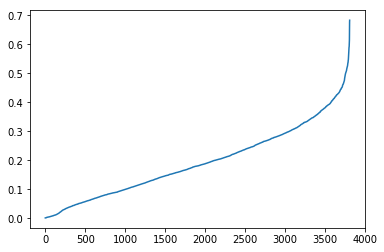

In [48]:
plt.plot(np.sort(np.mean(adv_val, axis=0)))

In [49]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_train, y_id))

clf = []
val_acc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = X_train.iloc[train_idx, :], y_id[train_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_id[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)

    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

clf.append(model_lgb)

[1]	valid_0's multi_logloss: 1.78357
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.63912
[3]	valid_0's multi_logloss: 1.52377
[4]	valid_0's multi_logloss: 1.42638
[5]	valid_0's multi_logloss: 1.34743
[6]	valid_0's multi_logloss: 1.27809
[7]	valid_0's multi_logloss: 1.21572
[8]	valid_0's multi_logloss: 1.15525
[9]	valid_0's multi_logloss: 1.10482
[10]	valid_0's multi_logloss: 1.06117
[11]	valid_0's multi_logloss: 1.01826
[12]	valid_0's multi_logloss: 0.979705
[13]	valid_0's multi_logloss: 0.944944
[14]	valid_0's multi_logloss: 0.913235
[15]	valid_0's multi_logloss: 0.881843
[16]	valid_0's multi_logloss: 0.852093
[17]	valid_0's multi_logloss: 0.825657
[18]	valid_0's multi_logloss: 0.801574
[19]	valid_0's multi_logloss: 0.780228
[20]	valid_0's multi_logloss: 0.760276
[21]	valid_0's multi_logloss: 0.742546
[22]	valid_0's multi_logloss: 0.723925
[23]	valid_0's multi_logloss: 0.706996
[24]	valid_0's multi_logloss: 0.690751
[25]	valid_0's multi_l

[25]	valid_0's multi_logloss: 0.628201
[26]	valid_0's multi_logloss: 0.61514
[27]	valid_0's multi_logloss: 0.600443
[28]	valid_0's multi_logloss: 0.583688
[29]	valid_0's multi_logloss: 0.570935
[30]	valid_0's multi_logloss: 0.559494
[31]	valid_0's multi_logloss: 0.547417
[32]	valid_0's multi_logloss: 0.536243
[33]	valid_0's multi_logloss: 0.526757
[34]	valid_0's multi_logloss: 0.518553
[35]	valid_0's multi_logloss: 0.508905
[36]	valid_0's multi_logloss: 0.501842
[37]	valid_0's multi_logloss: 0.492898
[38]	valid_0's multi_logloss: 0.48467
[39]	valid_0's multi_logloss: 0.476244
[40]	valid_0's multi_logloss: 0.468961
[41]	valid_0's multi_logloss: 0.462462
[42]	valid_0's multi_logloss: 0.455236
[43]	valid_0's multi_logloss: 0.450082
[44]	valid_0's multi_logloss: 0.444755
[45]	valid_0's multi_logloss: 0.439672
[46]	valid_0's multi_logloss: 0.433039
[47]	valid_0's multi_logloss: 0.425462
[48]	valid_0's multi_logloss: 0.419717
[49]	valid_0's multi_logloss: 0.414929
[50]	valid_0's multi_loglos

[237]	valid_0's multi_logloss: 0.261439
[238]	valid_0's multi_logloss: 0.26141
[239]	valid_0's multi_logloss: 0.261144
[240]	valid_0's multi_logloss: 0.260877
[241]	valid_0's multi_logloss: 0.260759
[242]	valid_0's multi_logloss: 0.260759
[243]	valid_0's multi_logloss: 0.261025
[244]	valid_0's multi_logloss: 0.260937
[245]	valid_0's multi_logloss: 0.261386
[246]	valid_0's multi_logloss: 0.261792
[247]	valid_0's multi_logloss: 0.261758
[248]	valid_0's multi_logloss: 0.261402
[249]	valid_0's multi_logloss: 0.261559
[250]	valid_0's multi_logloss: 0.2618
[251]	valid_0's multi_logloss: 0.261759
[252]	valid_0's multi_logloss: 0.261604
[253]	valid_0's multi_logloss: 0.261934
[254]	valid_0's multi_logloss: 0.261625
[255]	valid_0's multi_logloss: 0.262519
[256]	valid_0's multi_logloss: 0.262452
[257]	valid_0's multi_logloss: 0.262104
[258]	valid_0's multi_logloss: 0.26254
[259]	valid_0's multi_logloss: 0.263515
[260]	valid_0's multi_logloss: 0.264064
Early stopping, best iteration is:
[230]	val

[186]	valid_0's multi_logloss: 0.296325
[187]	valid_0's multi_logloss: 0.296721
[188]	valid_0's multi_logloss: 0.29729
[189]	valid_0's multi_logloss: 0.297163
[190]	valid_0's multi_logloss: 0.297468
[191]	valid_0's multi_logloss: 0.296747
[192]	valid_0's multi_logloss: 0.296628
[193]	valid_0's multi_logloss: 0.297103
[194]	valid_0's multi_logloss: 0.2965
[195]	valid_0's multi_logloss: 0.296194
[196]	valid_0's multi_logloss: 0.296449
[197]	valid_0's multi_logloss: 0.297246
[198]	valid_0's multi_logloss: 0.297002
[199]	valid_0's multi_logloss: 0.297213
[200]	valid_0's multi_logloss: 0.297296
[201]	valid_0's multi_logloss: 0.297476
[202]	valid_0's multi_logloss: 0.297315
[203]	valid_0's multi_logloss: 0.297153
[204]	valid_0's multi_logloss: 0.296689
[205]	valid_0's multi_logloss: 0.297817
[206]	valid_0's multi_logloss: 0.297747
[207]	valid_0's multi_logloss: 0.297575
[208]	valid_0's multi_logloss: 0.297716
[209]	valid_0's multi_logloss: 0.298425
[210]	valid_0's multi_logloss: 0.297623
[21

[9]	valid_0's multi_logloss: 1.09901
[10]	valid_0's multi_logloss: 1.0509
[11]	valid_0's multi_logloss: 1.00932
[12]	valid_0's multi_logloss: 0.969824
[13]	valid_0's multi_logloss: 0.932754
[14]	valid_0's multi_logloss: 0.898851
[15]	valid_0's multi_logloss: 0.866231
[16]	valid_0's multi_logloss: 0.835335
[17]	valid_0's multi_logloss: 0.807329
[18]	valid_0's multi_logloss: 0.781919
[19]	valid_0's multi_logloss: 0.757429
[20]	valid_0's multi_logloss: 0.736569
[21]	valid_0's multi_logloss: 0.714117
[22]	valid_0's multi_logloss: 0.693641
[23]	valid_0's multi_logloss: 0.675478
[24]	valid_0's multi_logloss: 0.657549
[25]	valid_0's multi_logloss: 0.641005
[26]	valid_0's multi_logloss: 0.625415
[27]	valid_0's multi_logloss: 0.610343
[28]	valid_0's multi_logloss: 0.596671
[29]	valid_0's multi_logloss: 0.582858
[30]	valid_0's multi_logloss: 0.571261
[31]	valid_0's multi_logloss: 0.559938
[32]	valid_0's multi_logloss: 0.549078
[33]	valid_0's multi_logloss: 0.537526
[34]	valid_0's multi_logloss: 

In [50]:
val_acc

[0.8772845953002611,
 0.9176470588235294,
 0.9146981627296588,
 0.8828947368421053,
 0.9075297225891678]

In [51]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=data_col).sort_values(by=0, ascending=False)

,0
rotated_acceleration_Y_abs_max,2640.553165
rotated_acceleration_Z_abs_max,2305.338223
rotated_acceleration_Y_mean,2125.833401
linear_acceleration_X_mean_abs_chg,1951.954175
angular_velocity_Y_mean_abs_chg,1934.453603
linear_acceleration_Y_mean_abs_chg,1926.389090
euler_Z_abs_max,1865.495635
euler_Z_abs_min,1707.837914
rotated_acceleration_Z_mean_abs_chg,1362.852824
rotated_acceleration_Y_max,1293.993604


In [52]:
preds_test = []

for model in clf:
    preds_test.append(model.predict(X_test))

In [53]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [54]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [55]:
test_surface = np.asarray(test_surface)

In [56]:
submission = pd.read_csv('../input/sample_submission.csv')

In [57]:
submission['surface'] = test_surface
submission.to_csv('../output/submission_5.csv', index=False)
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,carpet
4,4,soft_tiles
